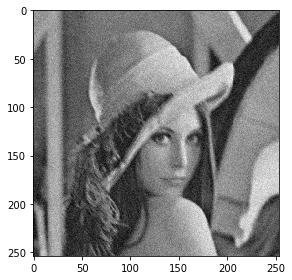

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import color, data, restoration
from skimage import io
from skimage.color import rgb2gray
from scipy.signal import convolve2d as conv2
from scipy.signal import gaussian
from numpy.fft import *
import time

tmpImg = io.imread('Lenna.jpg')
imgO = rgb2gray(tmpImg)

#平均濾波
psf = np.ones((5, 5)) / 25
img = conv2(imgO, psf, 'same')
#加入高斯噪點
img += 0.1 * img.std() * np.random.standard_normal(img.shape)

'''
製作出模糊照片
'''
bluredImg = np.copy(imgO)
h = np.eye(3) / 3
bluredImg = conv2(bluredImg, h, mode = 'valid')


gauss = np.random.normal(0, 0.04, np.shape(bluredImg))
noisy_img = bluredImg + gauss
noisy_img[noisy_img < 0] = 0
noisy_img[noisy_img > 255] = 255
io.imshow(noisy_img,cmap='gray')

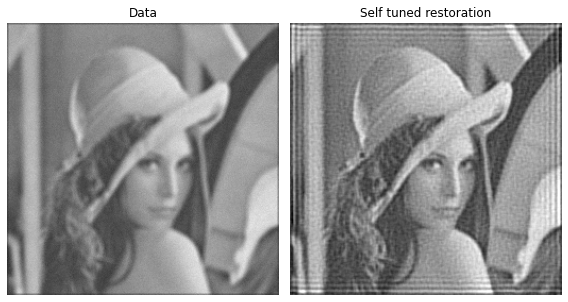

Time: 0.3113443851470947


In [2]:
'''
不用fft進行 Wiener filter
'''

start = time.time()
#利用unsupervised_wiener 輸入模糊的圖片和一開始的filter就可以反向restore圖片
deconvolved, _ = restoration.unsupervised_wiener(img, psf)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()
ax[0].imshow(img, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[0].axis('off')
ax[0].set_title('Data')

ax[1].imshow(deconvolved)
ax[1].axis('off')
ax[1].set_title('Wiener restoration')

fig.tight_layout()
plt.show()
#輸出運算時間
end = time.time()
print("Time:",end - start)

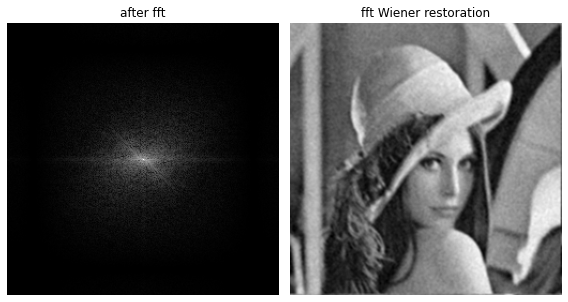

Time: 0.1399986743927002


In [3]:
'''
FFT Wiener filter
'''
from skimage import exposure
start = time.time()

#線合成一個高斯filter
h = gaussian(3, 1).reshape(3, 1)
h = np.dot(h, h.transpose())

#平均的高斯filter
kernel= h / np.sum(h)

kernel /= np.sum(kernel)

#先把模糊的圖片進行fft轉換
dummy = np.copy(noisy_img)
dummy = fft2(dummy)
kernel = fft2(kernel, s = noisy_img.shape)
#對fourier space的圖片進行 wiener處理
kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + 10)
dummy = dummy * kernel

#把圖片轉回原來的空間
final = np.abs(ifft2(dummy))
#讓fourier space中的圖片能顯示
cf1 = exposure.rescale_intensity(np.log(1+abs(fftshift(dummy))), out_range=(0.0, 1.0))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                       sharex=True, sharey=True)
plt.gray()
ax[0].imshow(cf1, vmin=cf1.min(), vmax=cf1.max())
ax[0].axis('off')
ax[0].set_title('after fft')

ax[1].imshow(final)
ax[1].axis('off')
ax[1].set_title('fft Wiener restoration')
fig.tight_layout()
plt.show()
#輸出運算時間
end = time.time()
print("Time:",end - start)